In [16]:
from IPython.display import HTML
HTML("<h1>The graph initialisation</h1>")

In [17]:
G = {"cluster1-cntx":["cluster1-cntx","cluster3-cntx"], "cluster2-cntx":["cluster2-cntx","cluster3-cntx"], "cluster3-cntx":["cluster3-cntx","cluster1-cntx","cluster2-cntx"]}
link_latency = {"cluster1-cntx":{"cluster1-cntx":1, "cluster3-cntx":10},"cluster2-cntx":{"cluster2-cntx":1, "cluster3-cntx":20}, "cluster3-cntx":{"cluster3-cntx":1, "cluster1-cntx":10,"cluster2-cntx":20}}
                                 
bf = {"firewall":{"firewalls":10, "firewallm":5, "firewalll":1}, "encrypt":{"encrypts":10, "encryptm":5, "encryptl":1}, "decrypt":{"decrypts":10, "decryptm":5, "decryptl":1}}
G_req = {"firewall":["encrypt"], "encrypt":["firewall"]}#, "decrypt":["firewall"]}
usecase = {1:{"firewall":300,"encrypt": 300, "decrypt":300, "SLA":10}, 2:{"firewall":100,"encrypt": 100}, "SLA": 100}
u =1
#G = {"cluster1-cntx":["cluster1-cntx", "cluster2-cntx"], "cluster2-cntx":["cluster2-cntx", "cluster1-cntx"]}
#link_latency = {"cluster1-cntx":{"cluster1-cntx":1, "cluster2-cntx":100}, "cluster2-cntx":{"cluster2-cntx":1, "cluster1-cntx":100}, "cluster3-cntx":{"cluster2-cntx":10, "cluster1-cntx":10}}


In [18]:
G["cluster1-cntx"]

['cluster1-cntx', 'cluster3-cntx']

In [19]:
from IPython.display import HTML
HTML("<h1>The graph illustration</h1>")

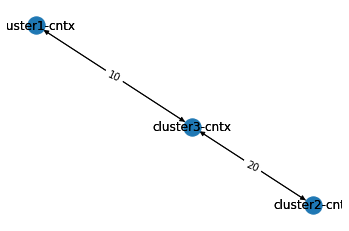

In [20]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pylab

def draw(G):
    infra = nx.DiGraph()
 #   for cl in range(len(G)):
 #       i = list(G.keys())[cl]
 #       infra.add_node(i)
    for cl in range(len(G)):
        i = list(G.keys())[cl]
        for link in range(len(G[i])):
            infra.add_edges_from([(i, G[i][link])], weight=link_latency[i][G[i][link]])
    edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in infra.edges(data=True)])


    pos = nx.spring_layout(infra)
    nx.draw_networkx_edge_labels(infra,pos,edge_labels=edge_labels)
    nx.draw_networkx_labels(infra, pos)
    #plt.figure(figsize=(8,8))
    
    nx.draw(infra, pos=pos, with_labels=True)
    plt.show()
    

draw(G)

In [28]:
#The number of running pods of a microservice on each cluster
import os
def runningPods(cluster, app_name): 
    output = os.popen('sudo kubectl top pod --context=' + cluster).read()
    lines = output.split("\n")
    numPods = 0
    which_app = len(app_name)
    for line in lines[:-1]:
        items = line.split()
        if len(items[0]) > 8 and items[0][:which_app] == app_name:
            numPods += 1
    return numPods
runningPods("cluster1-cntx","firewall"+'s')

1

In [29]:
#The utilised CPU of a microservice running on a cluster
import os
def getchar(string, n):
    return str(string)[n - 1]
def cpuUtilised(cluster, app_name):
    output = os.popen('kubectl top pod --context=' + cluster).read()
    lines = output.split("\n")
    which_app = len(app_name)
    cpu = ''
    cpu_u=0
    limits=0
    for line in lines[:-1]:
        items = line.split()
        if items[0][:which_app] == app_name:
            if getchar(items[0], which_app) == 's':
                cpu = items[1]
                cpu = cpu[:-1]
                cpu = int(cpu)
                cpu_u=cpu_u + cpu
            if getchar(items[0], which_app) == 'm':
                cpu = items[1]
                cpu = cpu[:-1]
                cpu = int(cpu)
                cpu_u=cpu_u + cpu
            if getchar(items[0], which_app) == 'l':
                cpu = items[1]
                cpu = cpu[:-1]
                cpu = int(cpu)
                cpu_u=cpu_u + cpu

        
                
#    print(limits - cpu_u)
    return cpu_u


cpuUtilised("cluster1-cntx","firewall"+'m')

0

In [30]:
#The available CPU of a microservice running on a cluster
import os
def getchar(string, n):
    return str(string)[n - 1]
def cpuAvail(cluster, app_name):
    output = os.popen('kubectl top pod --context=' + cluster).read()
    lines = output.split("\n")
    which_app = len(app_name)
    cpu = ''
    cpu_u=0
    limits=0
    for line in lines[:-1]:
        items = line.split()
        if items[0][:which_app] == app_name:
            if getchar(items[0], which_app) == 's':
                limits = 600
                cpu = items[1]
                cpu = cpu[:-1]
                cpu = int(cpu)
                cpu_u=cpu_u + cpu
            if getchar(items[0], which_app) == 'm':
                limits = 5*600
                cpu = items[1]
                cpu = cpu[:-1]
                cpu = int(cpu)
                cpu_u=cpu_u + cpu
            if getchar(items[0], which_app) == 'l':
                limits = 10*600
                cpu = items[1]
                cpu = cpu[:-1]
                cpu = int(cpu)
                cpu_u=cpu_u + cpu

        
                
#    print(limits - cpu_u)
    return limits - cpu_u


cpuAvail("cluster1-cntx","firewall"+'s')


600

In [33]:
#Which microservice configuration is running: small, medium, or large
def getchar(string, n):
    return str(string)[n - 1]
def whichConf(cluster, app_name):
    size = []
    output = os.popen('sudo kubectl get services --context=' + cluster).read()
    lines = output.split("\n")
    which_app = len(app_name)
    for line in lines[:-1]:
        items = line.split()
        if items[0][:which_app] == app_name:
            size.append(getchar(items[0], which_app+1))
    #        print(size)
    return size
whichConf("cluster1-cntx","firewall")
    

['s']

In [34]:
from IPython.display import HTML
HTML("<h1>Monitor and delete function</h1>")


In [35]:
#This function is terminate services once idle for a time 
import threading
import time
import os

def deletePod(app_name, timer, cluster):
    print("thread is starting")
    cpu = 0
    timeout = time.time() + timer
    while cpu == 0:
        cpu= cpuUtilised(cluster, app_name)
        if time.time() > timeout:
            try:
                os.system("sudo kubectl delete service "+ app_name +" --context=" + cluster)
                os.system("sudo kubectl delete deploy "+ app_name +" --context=" + cluster)
                print(app_name+ " timed out")
                break
            except:
                print("Service not found")
                break
        
def monitorUsage(cluster, timer):
    for service in range(len(bf)):
        threads = list()
        ser = list(bf.keys())[service]
        s = whichConf(cluster,ser)
        if s != []:
            for size in range(len(s)):
                app_name=ser+s[size]
                x =threading.Thread(target=deletePod, args=(app_name, timer, cluster,))
                x.daemon = True
                threads.append(x)
                x.start()
            for x in threads:
                x.join()

        
monitorUsage("cluster1-cntx",10)

thread is starting
firewalls timed out
thread is starting
encrypts timed out


In [36]:
#This function orders the running microservies on a cluster increasingly according to proccessing delay
def orderService(cluster, app_name):
    delay = []
    size = whichConf(cluster, app_name)
    for s in range(len(size)):
        delay.append(bf[app_name][app_name+size[s]])
    sorted_delay = [x for _,x in sorted(zip(delay,size))]
    return sorted_delay
 #   print(delay)
                
    
orderService("cluster1-cntx","firewall")
    

[]

In [51]:
import os
def getIP(cluster, app_name):
    output = os.popen('kubectl get service -o wide --context=' + cluster).read()
    lines = output.split("\n")
    serviceIP = ''
    port=''
    which_app = len(app_name)
    for line in lines[:-1]:
        items = line.split()
        if items[0][:which_app] == app_name:
            serviceIP=items[2]+":"+items[4][:4]
    return serviceIP
getIP("cluster1-cntx","firewall"+'m')

''

In [52]:
#This function orders the available links from source cluster increasingly according to latency
def orderlink(cluster):
    delay = []
    cnx = []
    for key in range(len(list(link_latency["cluster1-cntx"].keys()))):
        delay.append(link_latency["cluster1-cntx"][list(link_latency["cluster1-cntx"].keys())[key]])
        cnx.append(list(link_latency["cluster1-cntx"].keys())[key])
    sorted_delay = [x for _,x in sorted(zip(delay,cnx))]
    return sorted_delay
 #   print(delay)
                
    
orderlink("cluster1-cntx")

['cluster1-cntx', 'cluster3-cntx']

In [64]:
#Available CPU on a cluster in millicores
def clusterCPU(cluster):
    cpu=0
    cpu_cl=0
    output = os.popen('sudo kubectl top nodes --context=' + cluster).read()
    lines = output.split("\n")
    for line in lines[:-1]:
        items = line.split()
        if items[0] != "NAME":
            cpu = items[1]
            cpu = cpu[:-1]
            cpu = int(cpu)
            cpu_cl = cpu_cl + cpu
    #        print(size)
    return 2000 - cpu_cl

clusterCPU('cluster1-cntx')

-198

In [54]:
#Available CPU percentage on a cluster in
def clusterCPUPerc(cluster):
    cpu=0
    cpu_cl=0
    output = os.popen('sudo kubectl top nodes --context=' + cluster).read()
    lines = output.split("\n")
    for line in lines[:-1]:
        items = line.split()
        if items[0] != "NAME":
            cpu = items[2]
            cpu = cpu[:-1]
            cpu = int(cpu)
            cpu_cl = cpu_cl + cpu
    #        print(size)
    return cpu_cl/3

clusterCPUPerc('cluster1-cntx')

35.333333333333336

In [55]:
#Available memory on a cluster in MB
def clusterMem(cluster):
    mem=0
    mem_cl=0
    nodes=0
    output = os.popen('sudo kubectl top nodes --context=' + cluster).read()
    lines = output.split("\n")
    for line in lines[:-1]:
        items = line.split()
        if items[0] != "NAME":
            mem = items[3]
            mem = mem[:len(mem)-2]
            nodes=nodes+1
            mem = int(mem)
            mem_cl = mem_cl + mem
    #print(nodes)
    #print(mem_cl)
    return nodes*1915 - mem_cl

clusterMem('cluster2-cntx')

1572

In [56]:
from IPython.display import HTML
HTML("<h1>Place and Assign new mircroservice to requests</h1>")

In [57]:
def place(i, q, s):
#    i = 'cluster2-cntx'
    if s == 's':
        os.system('sudo kubectl apply -f ~/SOCKS-deployement/'+q+'-S.yaml --context=' + i)
    elif s == 'm':
        os.system('sudo kubectl apply -f ~/SOCKS-deployement/'+q+'-M.yaml --context=' + i)
    elif s == 'l':
        os.system('sudo kubectl apply -f ~/SOCKS-deployement/'+q+'-L.yaml --context=' + i)
    

In [58]:
def assignService(i, q, usecase_s):
#    req = 1
#    cl = 1
    proxy_conf='' 
    size=[]
    avail=0
    cpu_q= usecase_s[u][q]
    r = runningPods(i, q)
    if r >= 1: #there's a function already running on this cluster 
        size = orderService(i,q) #which function size is running? order by delay
        for s in range(len(size)): 
            avail = cpuAvail(i, q+size[s]) #the available CPU depends on the service configuration
            if avail > cpu_q: #if the available resources > profiled resources requested 
                proxy_conf=getIP(i,q+size[s]) #then get IP to assign the service to proxy
                break
    elif r ==0 : #no service running 
        proxy_conf=''          
    #print(proxy_conf)
    return proxy_conf

def newService(i,q, usecase_s):
    proxy_conf=''
    cpu_q= usecase_s[u][q]
    r = runningPods(i, q)
    if 600 > cpu_q and runningPods(i, q+'s') == 0 and 600 < clusterCPU(i): #deploy new small service
        place(i,q,'s')
        proxy_conf=getIP(i,q+'s')       
    elif 5*600 > cpu_q and runningPods(i, q+'m')==0 and 5*600 < clusterCPU(i): #deploy new medium service
        proxy_conf=getIP(i,q+'m')
        proxy_conf=getIP(i,q+'m')
    elif 10*600 > cpu_q and runningPods(i, q+'l')==0 and 10*600 < clusterCPU(i): #deploy new large service
        proxy_conf=getIP(i,q+'l')
        proxy_conf=getIP(i,q+'l')
  #  elif proxy_conf=='':
  #      print("placement failed")
        
    
    #print(proxy_conf)
    return proxy_conf

In [59]:
#Returns the lists of clusters on which a microservice type is running
def checkdeploy(app_name):
    cl = 0
    p=0
    cluster=[]
    while p == 0:
        for cl in range(len(G)):
            i = list(G.keys())[cl]
            output = os.popen('sudo kubectl get services --context=' +i).read()
            lines = output.split("\n")
            which_app = len(app_name)
            for line in lines[:-1]:
                items = line.split()
                if items[0][:which_app] == app_name:
                    cluster.append(i)
                    p=1
                    
    return cluster
checkdeploy("proxy")
            

['cluster1-cntx', 'cluster2-cntx']

In [60]:
def proxyConfig(IP, proxy):
    newChain = []
    for ip in range(len(IP)):
        newChain.append('"-c",'+'"socks6://'+IP[ip]+'",')
    newChain = ''.join(newChain)
    newChain = newChain[:-1]
    print(newChain)
    os.system("sudo kubectl patch deployment "+ proxy +" --namespace default --type='json' -p='[{'op': 'replace', 'path': '/spec/template/spec/containers/0/args', 'value': ["+newChain+"]}]'")

In [65]:
def main(proxy, G_req):
    IPs = []
    m_cl= ''
    m_ser=[]
    proxy_idx=proxy
    startingCluster = checkdeploy(proxy_idx)
    OG = orderlink(startingCluster) #try the fastest link first
    for cl in range(len(OG)): #go over clusters 
        i = list(G.keys())[cl]
        for req in range(len(G_req)):
            q = list(G_req.keys())[req] #go over functions to deploy
            if req == 0 and q not in m_ser: #The first function can be deployed on any cluster
                if assignService(i,q, usecase) != "": #there is atleast one good candidate service running on i 
                    IPs.append(assignService(i,q, usecase))
                    m_cl= i #to check connection with next deployment
                    m_ser.append(q)
                    continue                
            elif m_cl in G[i] and q not in m_ser: #connection with previous bf and not already deployed
                if assignService(i,q, usecase) != "": #can be deployed
                    IPs.append(assignService(i,q, usecase))
                    m_cl= i
                    m_ser.append(q)
                    continue
        if len(m_ser) < len(G_req): #not all deployed yet we try a different cluster      
            continue 
        else:
            break
    if len(m_ser) < len(G_req): #not all functions could be deployed 
        for cl in range(len(OG)): #go over clusters 
            i = list(G.keys())[cl]
            for req in range(len(G_req)):
                q = list(G_req.keys())[req] #go over functions to deploy
                if req == 0 and q not in m_ser:
                    if newService(i,q, usecase) != '':
                        IPs.append(newService(i,q, usecase))
                        m_cl= i
                        m_ser.append(q)
                        continue
                elif m_cl in G[i] and q not in m_ser: #connection with previous bf and not already deployed
                        if newService(i,q, usecase) != '':
                            IPs.append(newService(i,q, usecase))
                            m_cl= i
                            m_ser.append(q)
                            continue  
    proxyConfig(IPs, proxy)
    print(IPs)
    print(m_ser)
    
main("proxy", G_req)

KeyboardInterrupt: 

In [66]:
from IPython.display import HTML
HTML("<h1>Deploy and monitor microservices</h1>")

In [ ]:
threads = list()
x =ThreadWithResult(target=main)
x.daemon = True
x.start()
threads.append(x)
for cl in range(len(G)): #go over clusters 
        i = list(G.keys())[cl]
        x = ThreadWithResult(target=monitorUsage, args=(i,10, ))
        x.daemon = True
        threads.append(x)
        x.start()
for x in threads:
    x.join()
    print(x.result)